In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import networkx as nx
import seaborn as sns
from scipy.optimize import minimize
from sklearn.cluster import KMeans
import statsmodels.api as sm

In [2]:
# Import the output data
data = pd.read_csv('outputdata.csv')

# Convert 'date' to date format and rename to 'date'
data['date'] = pd.to_datetime(data['date'])

# Import the output matrix.
s_matrix=np.load('spillover_matrix.npy')

# Set data series.
date_series = data.loc[ : ,'date']
date_series = date_series.dt.date

# Set the currencies list.
var_list = data.columns[1:21]

# Set the global mapping font
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 12  # 可以设置字体大小

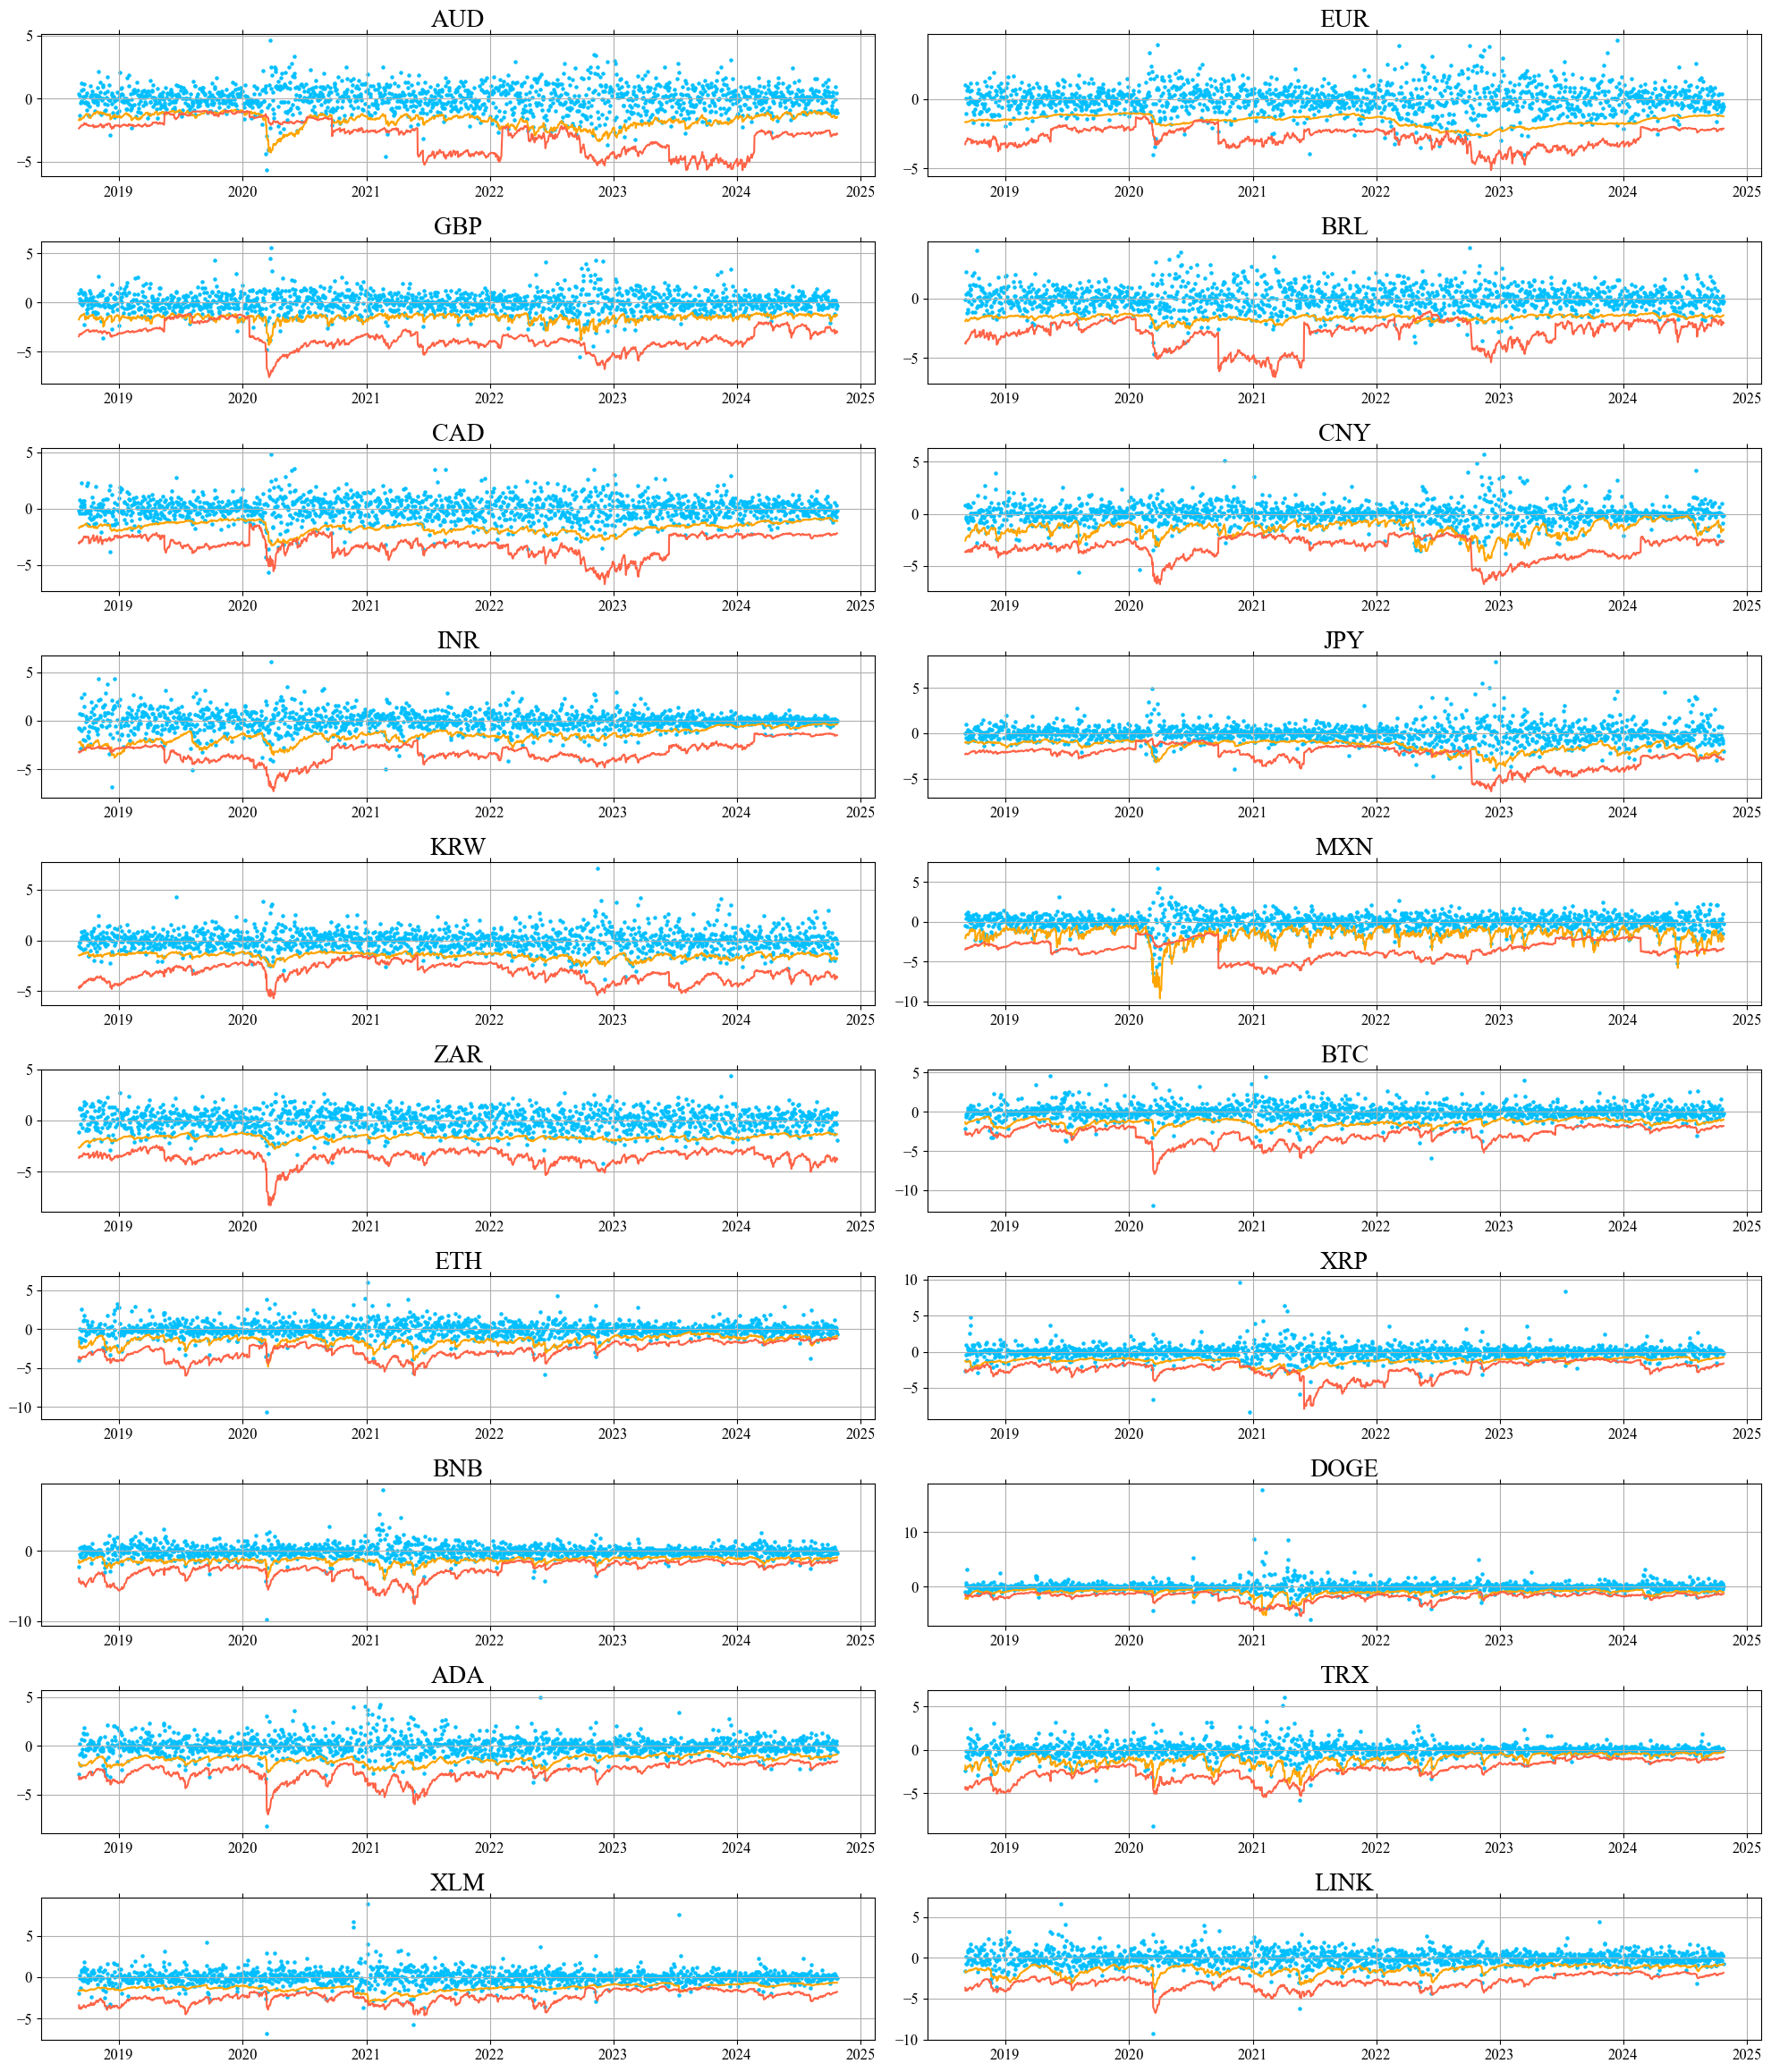

In [3]:
## Draw yield point plots, VaR and CoVaR plots
# Calculate the number of rows required to accommodate all subgraphs
nrows = (len(var_list) + 1) // 2

# Create shapes and axes, adjust aspect ratios
fig, axes = plt.subplots(nrows, 2, figsize=(20, 14 / 6 * nrows), sharex=True)

# If there is only one subgraph, axes are not arrays and need to be converted to arrays
if len(var_list) == 1:
    axes = [axes]

# Traverse each currency and plot the data
for i, currency in enumerate(var_list):
    ax = axes[i // 2, i % 2]  # Getting the correct subgraph location

    # Plotting raw currency values
    ax.scatter(data['date'], data[currency], color='deepskyblue', s=5)  

    # Plotting the currency VaR line
    ax.plot(data['date'], data[f'{currency}_VaR'], color='orange' )

    # Mapping the currency CoVaR line
    ax.plot(data['date'], data[f'{currency}_CoVaR'], color='tomato')


    # Add titles and tags
    ax.set_title(f'{currency}',size=20)
    ax.grid(True)  # Display gridlines

    # Setting the scale visible
    ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, left=True, labelleft=True)

# Adjust subgraph spacing
plt.tight_layout()
# Save graphics
plt.savefig('VaR_CoVaR.pdf', bbox_inches='tight')
# Display graphics
plt.show()


In [6]:
# Initialise the adjusted risk contagion matrix
a_s_matrix = []
sfi_series = []
shi_series = []
ret_series = []
fenmu_series = []

# Calculate adjusted risk contagion matrix
for t in range(len(s_matrix)):

    # Extraction of the adjacency matrix and the VaR and CoVaR sequences
    s_matrix_t = s_matrix[t]
    VaR_values_t =1+np.abs(np.array([data.iloc[t][f'{company}_VaR'] for company in var_list]))
    CoVaR_values_t =1+np.abs(np.array([data.iloc[t][f'{company}_CoVaR'] for company in var_list]))
    ret_values_t = 1+np.abs(np.array([data.iloc[t][f'{company}'] for company in var_list]))
    i_vector = np.ones(20)
    # Diagonalise sequences to facilitate SNRI calculation
    diag_VaR_values_t =np.diag(VaR_values_t)
    diag_CoVaR_values_t =np.diag(CoVaR_values_t)
    
    # Calculate SFI,SHI
    sfi_series_t = s_matrix_t@VaR_values_t
    ret_series_t = s_matrix_t@ret_values_t
    fenmu_sfi_t = s_matrix_t@i_vector
    shi_series_t = CoVaR_values_t@s_matrix_t
    a_s_matrix_t = diag_CoVaR_values_t@s_matrix_t@diag_VaR_values_t

    sfi_series.append(sfi_series_t)
    fenmu_series.append(fenmu_sfi_t)
    ret_series.append(ret_series_t)
    shi_series.append(shi_series_t)
    a_s_matrix.append(a_s_matrix_t)

sfi_series = np.array(sfi_series)
ret_series = np.array(ret_series)
fenmu_series = np.array(fenmu_series)
shi_series = np.array(shi_series)
a_s_matrix = np.array(a_s_matrix)

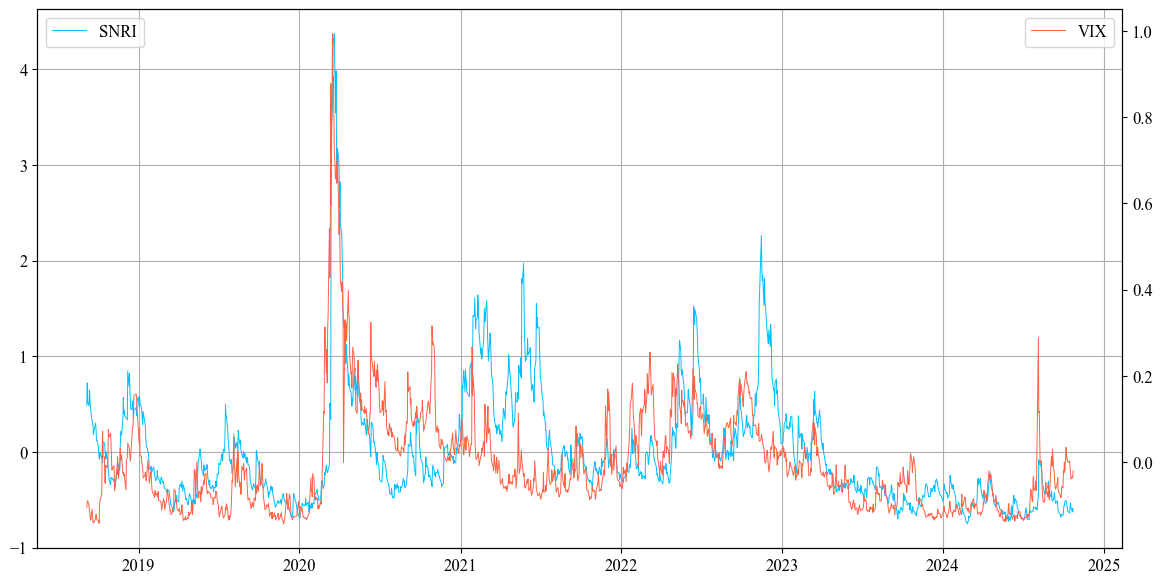

0.6401946930807657


In [8]:
## Extract the vix index data and merge it with the data set.
vix = pd.read_csv('VIX.csv')
vix['date'] = pd.to_datetime(vix['date'])
vix_data = pd.merge(data,vix,how='left',on='date')

#Calculate standardised vix data
vix_series = vix_data.loc[ : ,'VIX']
vix_series = (vix_series-np.mean(vix_series))/np.var(vix_series, ddof = 1)


# Calculate standardised average risk premium intensity
total_t = np.sum(np.sum(a_s_matrix,axis=1),axis=1)/380
total_t = (total_t-np.mean(total_t))/np.var(total_t, ddof = 1)


# Create a new dataframe with date columns and VIX columns
df_new = pd.DataFrame({'date': date_series,'total':total_t,'vix':vix_series})
# Mean padding for missing values in VIX columns
df_new['vix'] = df_new['vix'].fillna(df_new['vix'].mean())

# Plotting spillover intensity and VIX time-variance
fig, ax1 = plt.subplots(figsize=(14, 7))
# Draw the total timing line
ax1.plot(df_new['date'], df_new['total'], color='deepskyblue', label='SNRI',linewidth=0.7)
ax1.tick_params('y', colors='black')
ax1.legend(loc='upper left')

# Create secondary vertical axes
ax2 = ax1.twinx()
ax2.plot(df_new['date'], df_new['vix'], color='tomato', label='VIX',linewidth=0.7)
ax2.tick_params('y', colors='black')
ax2.legend(loc='upper right')

# Display grid
ax1.grid(True)

# Show charts
plt.savefig('total_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Calculate cosine similarity
cos_smi = df_new['total'].dot(df_new['vix']) / (np.linalg.norm(df_new['vix']) * np.linalg.norm(df_new['total']))
print(cos_smi)

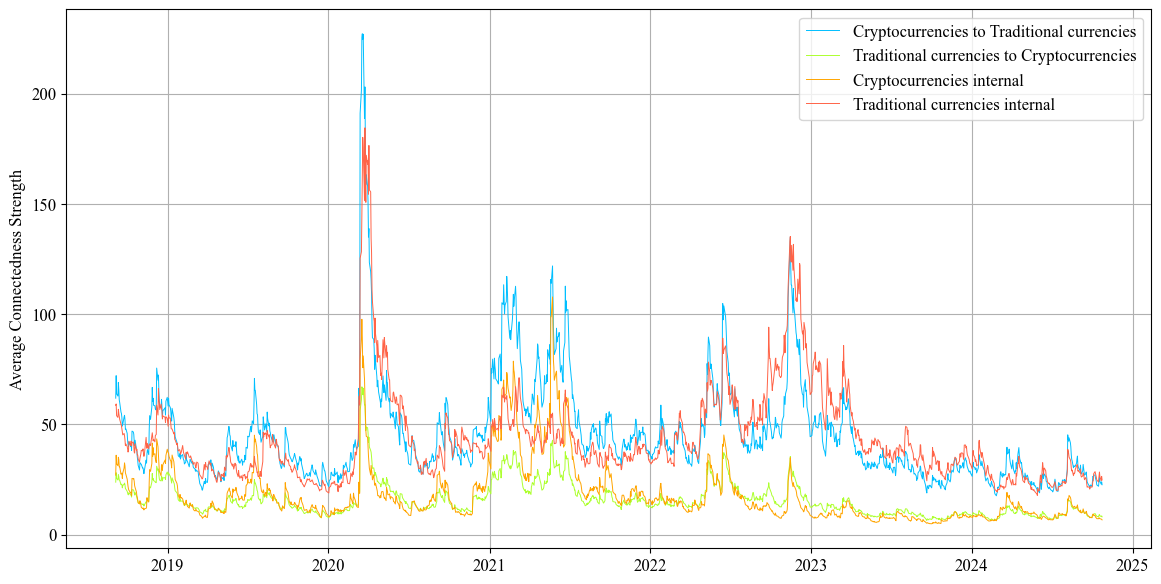

In [9]:
## Draw time-varying diagrams of matrix components
# Calculate the average strength of each chunk
c_e = a_s_matrix[:, 0:11, 11:20]
c_e_b = c_e.sum(axis=1)
c_e_t = c_e_b.sum(axis=1)/99**0.5

e_c = a_s_matrix[:, 11:20, 0:11]
e_c_b = e_c.sum(axis=1)
e_c_t = e_c_b.sum(axis=1)/99**0.5

e_in = a_s_matrix[:, 0:11, 0:11]
e_in_b = e_in.sum(axis=1)
e_in_t = e_in_b.sum(axis=1)/110**0.5

c_in = a_s_matrix[:, 11:20, 11:20]
c_in_b = c_in.sum(axis=1)
c_in_t = c_in_b.sum(axis=1)/72**0.5

date_series = data['date']
# Create a new dataframe with a date column and four time series
df_new = pd.DataFrame({'date': date_series, 'c to e': c_e_t,'e to c': e_c_t, 'e in':e_in_t, 'c in':c_in_t,})
# Create graphs and axes
fig, ax = plt.subplots(figsize=(14, 7))
# Plotting four time series lines
ax.plot(df_new['date'], df_new['c to e'], color='deepskyblue', label='Cryptocurrencies to Traditional currencies',linewidth=0.7)  # s参数设置点的大小
ax.plot(df_new['date'], df_new['e to c'], color='greenyellow', label='Traditional currencies to Cryptocurrencies',linewidth=0.7)
ax.plot(df_new['date'], df_new['c in'], color='orange', label='Cryptocurrencies internal',linewidth=0.7)
ax.plot(df_new['date'], df_new['e in'], color='tomato', label='Traditional currencies internal',linewidth=0.7)
# Add legend
ax.legend()
# Add titles and tags
ax.set_ylabel('Average Connectedness Strength')
# Display grid
ax.grid(True)
# Show charts
plt.savefig('part_plot.pdf', dpi=300, bbox_inches='tight')


In [7]:
def remove_diag_and_flatten(arr):
    # Get the dimensions of the second and third dimensions
    rows, cols = arr.shape[1], arr.shape[2]
    # Initialise an empty list to store non-diagonal elements
    non_diag_elements = []
    # Iterate over the matrix, skipping diagonal elements
    for i in range(rows):
        for j in range(cols):
            if i != j:  # Skip diagonal elements
                non_diag_elements.append(arr[:, i, j])
    # Merge the elements of the list into a one-dimensional array
    flattened_array = np.concatenate(non_diag_elements)
    return flattened_array

test = remove_diag_and_flatten(a_s_matrix)

In [8]:
## Calculate the threshold value
kmeans = KMeans(n_clusters=2)
kmeans.fit(test.reshape(-1, 1))
labels = kmeans.labels_
threshold = (kmeans.cluster_centers_[0] + kmeans.cluster_centers_[1]) / 2
threshold 

array([8.1641875])

In [9]:
## Calculate the matrix after flit
edge_matrix = [[[0 for _ in range(20)] for _ in range(20)] for _ in range(1530)]
edge_matrix = np.array(edge_matrix )
for i in range(1530):
    for j in range(20):
        for p in range(20):
            if a_s_matrix[i,j,p]>=threshold :
                edge_matrix[i,j,p] = 1
            else:
                edge_matrix[i,j,p] = 0

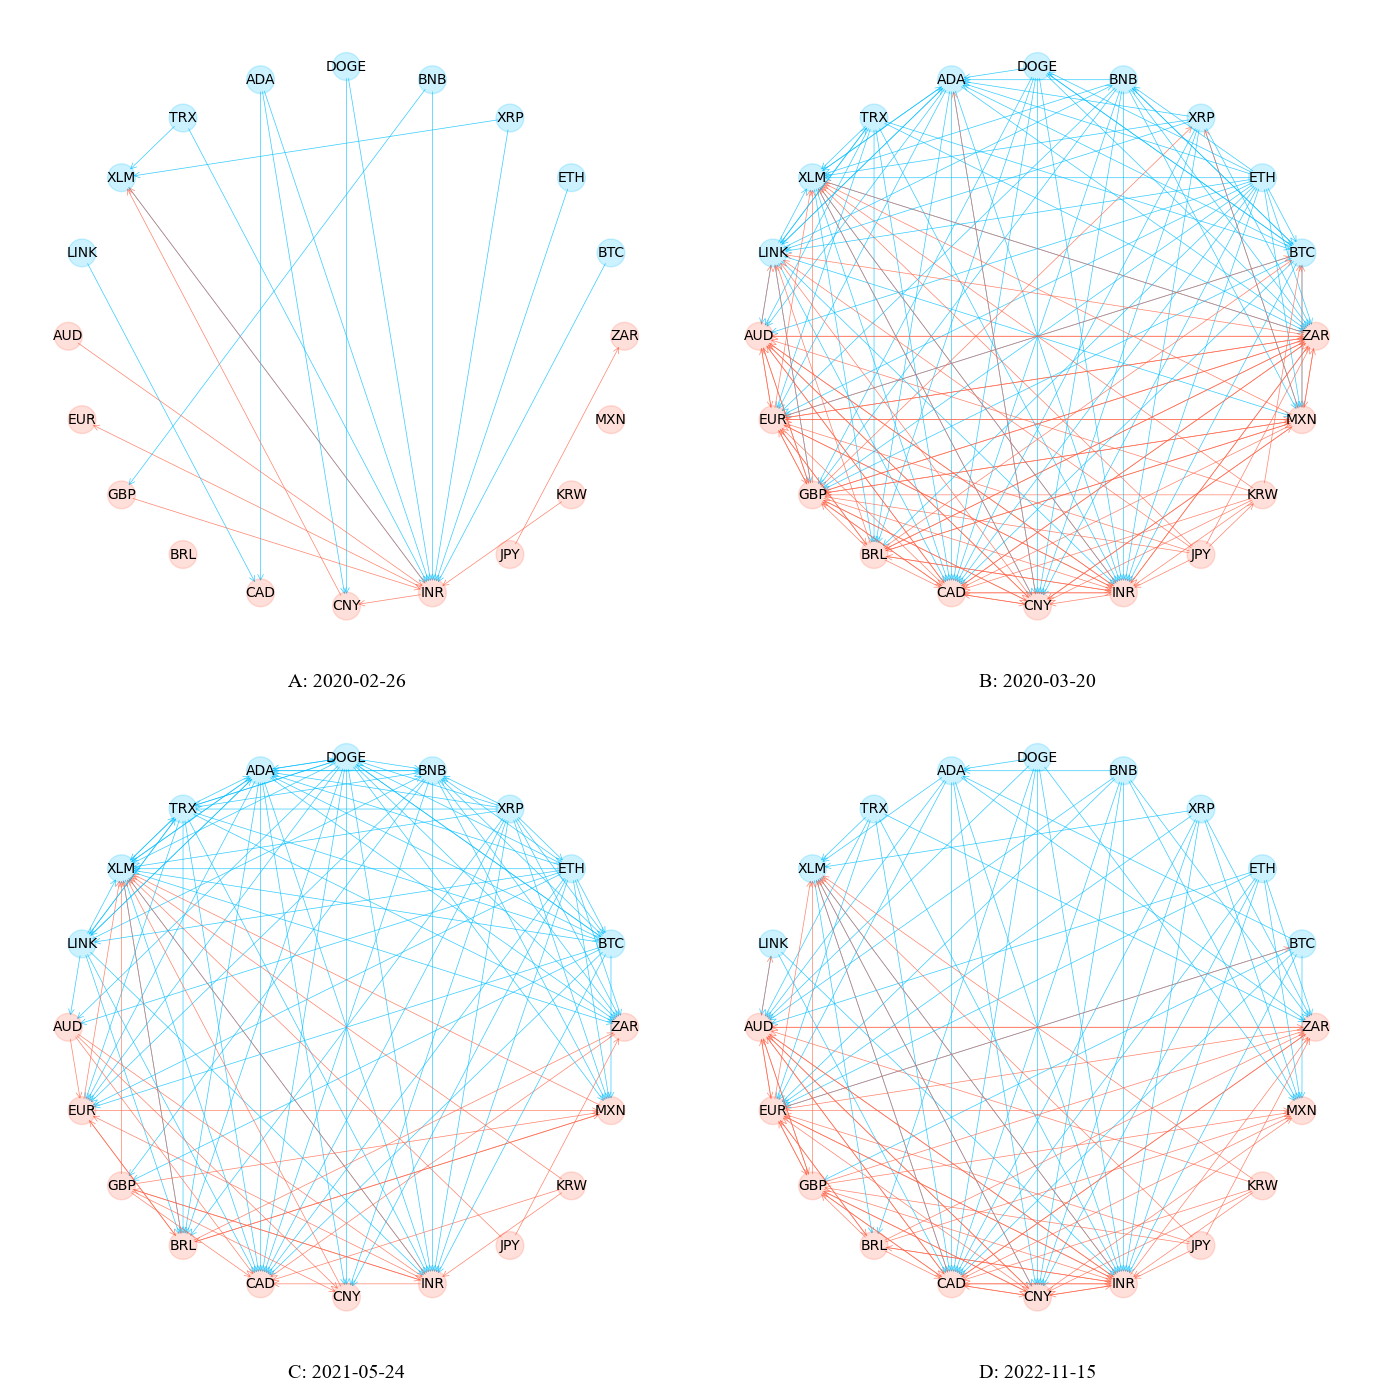

In [54]:
is_values = [364, 381, 674, 1044]  # Input time node values
# Create a 2x2 subgraph grid
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Adjusting the figsize to fit the display
panels = ['A','B','C','D']

# Iterate over the four i-values
for i, ax ,panel in zip(is_values, axs.flatten(),panels):
    M = edge_matrix[i]
    G = nx.from_numpy_array(M, create_using=nx.DiGraph())
    value = data.iloc[i, data.columns.get_loc('date')]
    date_value = value.date()
    pos = nx.shell_layout(G)  # Setting up the layout for the diagram
    # Set the colour for each node
    node_colors = []
    for v in G.nodes():
        # Set the colour of the edge based on the node value
        if   v < 11:
            node_colors.append('tomato')
        else :
            node_colors.append('deepskyblue')
    # Drawing nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400, alpha=0.2, ax=ax)

    # Set the colour for each edge
    edge_colors = []
    for u, v in G.edges():
        # Set the colour of the edge based on the node value
        if v < 11:
            edge_colors.append('tomato')
        else:
            edge_colors.append('deepskyblue')

    # Drawing the edge
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color=edge_colors, alpha=0.8, arrows=True, arrowstyle="<-", arrowsize=10, ax=ax)

    # Drawing node labels
    labels = {i: var_list[i] for i in range(len(G))}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)

    # Setting the Submap Title
    ax.set_title(panel + ': ' + str(date_value), y=-0.05)

    # Remove subgraph borders
    for spine in ax.spines.values():
        spine.set_visible(False)

# Adjust subgraph spacing
plt.tight_layout()
# Show chart
plt.savefig('network.pdf', dpi=300, bbox_inches='tight')

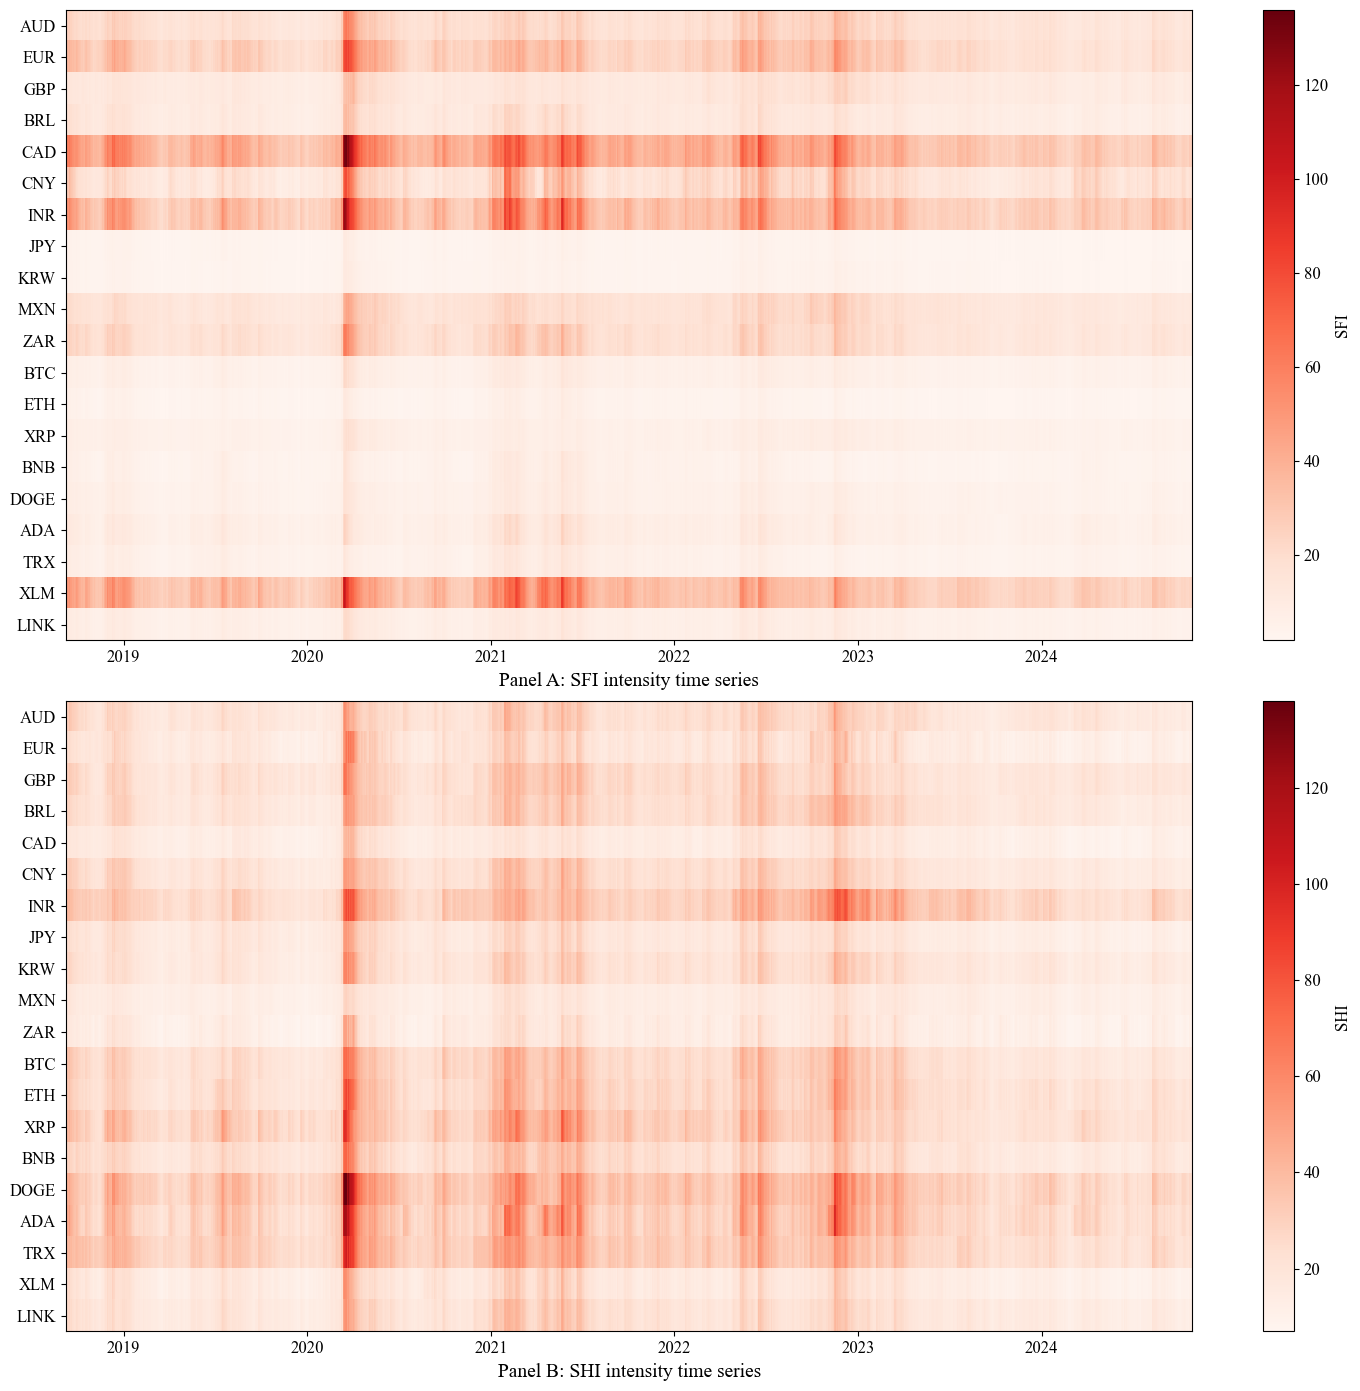

In [11]:
year_series = [date.strftime('%Y') for date in date_series]

years = [date.split('-')[0] for date in year_series]  # Assuming a date format of 'YYYY-MM-DD'
unique_years = sorted(set(years))  # Remove duplicate years and sort
# Find the index of the first occurrence of each year
boundary_indices = [years.index(year) for year in unique_years]
# If you don't want to display the first year, you can skip the first element of the boundary_indices
if boundary_indices:
    boundary_indices = boundary_indices[1:]

# Create a graphics window and set the subgraph layout to be top and bottom aligned
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))  # 2行1列

# Draw the first subplot
im1 = ax1.imshow(np.transpose(sfi_series), cmap='Reds', interpolation='nearest', aspect='auto')
# Set the x-axis scale position and labelling to show only the years of the year boundary (except the first one)
ax1.set_xticks(np.arange(len(year_series))[boundary_indices])
ax1.set_xticklabels([year_series[i].split('-')[0] for i in boundary_indices])
# Set the y-axis scale position and labels
ax1.set_yticks(np.arange(len(var_list)))
ax1.set_yticklabels(var_list)
# Add a colour bar
fig.colorbar(im1, ax=ax1, label='SFI')
# Title added
ax1.text(0.5, -0.05, 'Panel A: SFI intensity time series', ha='center', va='top', transform=ax1.transAxes,fontsize=14)

# Draw the second subgraph
im2 = ax2.imshow(np.transpose(shi_series), cmap='Reds', interpolation='nearest', aspect='auto')
# Set the x-axis scale position and labelling to show only the years of the year boundary (except the first one)
ax2.set_xticks(np.arange(len(year_series))[boundary_indices])
ax2.set_xticklabels([year_series[i].split('-')[0] for i in boundary_indices])
# Set the y-axis scale position and labels
ax2.set_yticks(np.arange(len(var_list)))
ax2.set_yticklabels(var_list)
# Add a colour bar
fig.colorbar(im2, ax=ax2, label='SHI')
# Title added
ax2.text(0.5, -0.05, 'Panel B: SHI intensity time series', ha='center', va='top', transform=ax2.transAxes,fontsize=14)

# Adjust subgraph spacing
plt.tight_layout()

# Display image
plt.savefig('SFI_and_SHI_series.pdf', dpi=300, bbox_inches='tight')

In [40]:
# Calculate the centrality of the graph
between_df = pd.DataFrame(columns= var_list)
closeness_df = pd.DataFrame(columns= var_list)
for t in range(len(edge_matrix)):
    bet_cen_t = edge_matrix[t]
    G_t = nx.from_numpy_array(bet_cen_t, create_using=nx.DiGraph())
    betweenness_t = list((nx.betweenness_centrality(G_t)).values())
    closeness_t = list((nx.closeness_centrality(G_t)).values())
    between_df.loc[t] = betweenness_t
    closeness_df.loc[t] = closeness_t
bet_series = np.array(between_df)
clo_series = np.array(closeness_df)

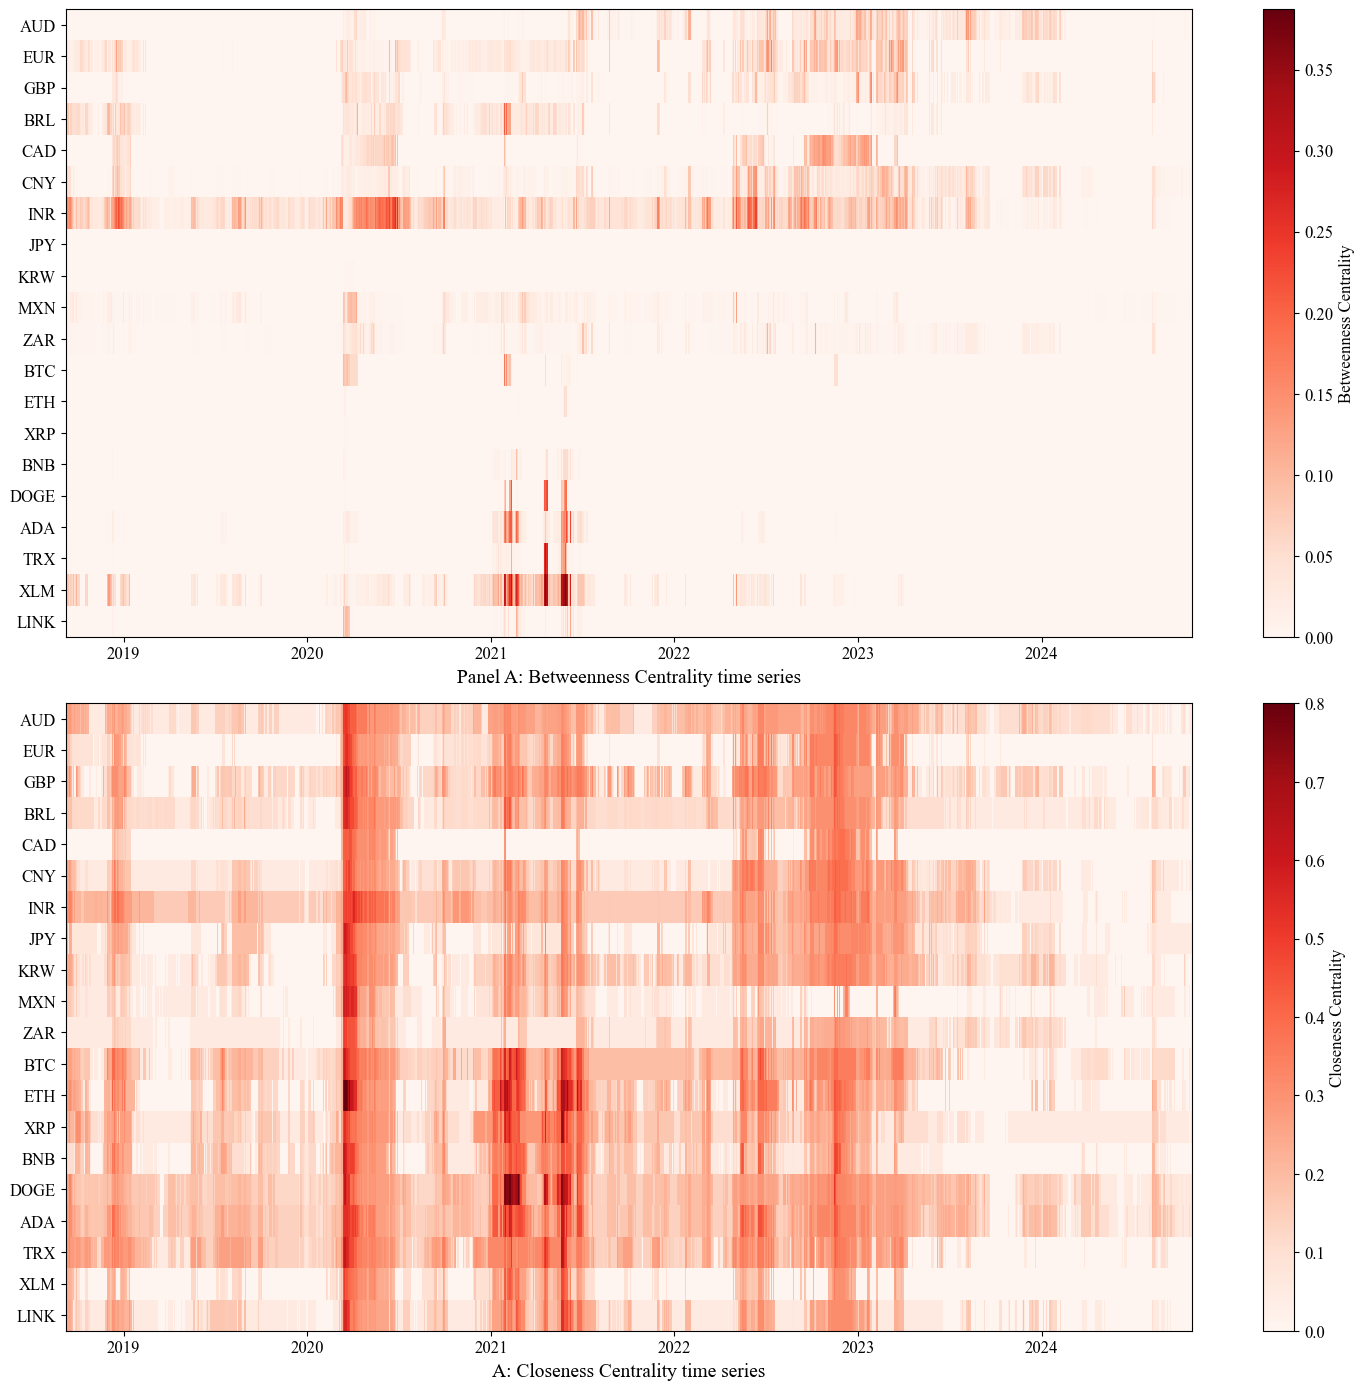

In [42]:
year_series = [date.strftime('%Y') for date in date_series]

years = [date.split('-')[0] for date in year_series]  # Assuming a date format of 'YYYY-MM-DD'
unique_years = sorted(set(years))  # Remove duplicate years and sort
# Find the index of the first occurrence of each year
boundary_indices = [years.index(year) for year in unique_years]
# If you don't want to show the first year, you can skip the first element of boundary_indices
if boundary_indices:
    boundary_indices = boundary_indices[1:]

# Create a graphics window and set the subgraph layout to be top and bottom aligned
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))  # 2行1列

# Draw the first subplot
im1 = ax1.imshow(np.transpose(bet_series), cmap='Reds', interpolation='nearest', aspect='auto')
# Set the x-axis scale position and labelling to show only the years of the year boundary (except the first one)
ax1.set_xticks(np.arange(len(year_series))[boundary_indices])
ax1.set_xticklabels([year_series[i].split('-')[0] for i in boundary_indices])
# Set the y-axis scale position and labels
ax1.set_yticks(np.arange(len(var_list)))
ax1.set_yticklabels(var_list)
# Add a colour bar
fig.colorbar(im1, ax=ax1, label='Betweenness Centrality')
# Title added
ax1.text(0.5, -0.05, 'Panel A: Betweenness Centrality time series', ha='center', va='top', transform=ax1.transAxes,fontsize=14)

# Draw the second subgraph
im2 = ax2.imshow(np.transpose(clo_series), cmap='Reds', interpolation='nearest', aspect='auto')
# Set the x-axis scale position and labelling to show only the years of the year boundary (except the first one)
ax2.set_xticks(np.arange(len(year_series))[boundary_indices])
ax2.set_xticklabels([year_series[i].split('-')[0] for i in boundary_indices])
# Set the y-axis scale position and labels
ax2.set_yticks(np.arange(len(var_list)))
ax2.set_yticklabels(var_list)
# Add a colour bar
fig.colorbar(im2, ax=ax2, label='Closeness Centrality')
# Title added
ax2.text(0.5, -0.05, 'A: Closeness Centrality time series', ha='center', va='top', transform=ax2.transAxes,fontsize=14)

# Adjust subgraph spacing
plt.tight_layout()

# Display image
plt.savefig('Centrality.pdf', dpi=300, bbox_inches='tight')

In [14]:
#Define the list of traditional and cryptocurrency separations
cry_list=var_list[11:20]
exc_list=var_list[0:11]

# Extract the time-varying matrix of the separate impacts of traditional currencies on cryptocurrencies
e_c_tv = (a_s_matrix[:,11:20,0:11])
c_e_tv = (a_s_matrix[:,0:11,11:20])

In [15]:

## Calculation of average impact
start_num = 0
end_num = 1529
start_date = date_series[start_num]
end_date = date_series[end_num]

e_c_avg = np.mean(e_c_tv[start_num:end_num],axis=0)
e_c_avg = e_c_avg.T
c_e_avg = np.mean(c_e_tv[start_num:end_num],axis=0)

c_e_df = pd.DataFrame(c_e_avg, columns=cry_list)
e_c_df = pd.DataFrame(e_c_avg, columns=cry_list)

# Initialise a data frame to load sorted variables
c_e_postrank_df=pd.DataFrame()
e_c_postrank_df=pd.DataFrame()

#Cryptocurrency pairs exchange rates sorted
for column in c_e_df.columns:
    rank_df = pd.DataFrame({'exchange_list':exc_list, 'value':c_e_df[column]})
    sorted_df = rank_df.sort_values(by='value', ascending=False)

    # Add the sorted results to the data frame
    sorted_name = np.array(sorted_df['exchange_list'])
    c_e_postrank_df[column]=sorted_name

#Exchange rates sorted against cryptocurrencies
for column in e_c_df.columns:
    rank_df = pd.DataFrame({'exchange_list':exc_list, 'value':e_c_df[column]})
    sorted_df = rank_df.sort_values(by='value', ascending=False)

    # Add the sorted results to the data frame
    sorted_name = np.array(sorted_df['exchange_list'])
    e_c_postrank_df[column]=sorted_name
    
# Splicing two data frames
df_concatenated = pd.concat([c_e_postrank_df,  e_c_postrank_df], axis=1)  
print(start_date,end_date)
print(df_concatenated)

2018-09-05 00:00:00 2024-10-23 00:00:00
    BTC  ETH  XRP  BNB DOGE  ADA  TRX  XLM LINK  BTC  ETH  XRP  BNB DOGE  ADA  \
0   CAD  CAD  CAD  CAD  INR  INR  INR  INR  CAD  BRL  INR  EUR  BRL  CNY  CNY   
1   INR  INR  ZAR  ZAR  CNY  CAD  EUR  BRL  INR  EUR  JPY  ZAR  KRW  EUR  CAD   
2   MXN  CNY  INR  INR  CAD  CNY  ZAR  CAD  AUD  KRW  CAD  MXN  ZAR  BRL  JPY   
3   EUR  EUR  MXN  MXN  GBP  EUR  CAD  ZAR  GBP  MXN  AUD  GBP  AUD  JPY  EUR   
4   GBP  AUD  EUR  EUR  AUD  ZAR  BRL  EUR  MXN  AUD  CNY  CAD  GBP  KRW  GBP   
5   BRL  MXN  CNY  GBP  BRL  AUD  AUD  CNY  JPY  INR  KRW  INR  CAD  MXN  ZAR   
6   ZAR  ZAR  BRL  AUD  MXN  BRL  CNY  AUD  CNY  GBP  ZAR  KRW  EUR  ZAR  AUD   
7   JPY  BRL  AUD  CNY  ZAR  GBP  GBP  KRW  KRW  JPY  MXN  JPY  CNY  AUD  BRL   
8   KRW  GBP  GBP  KRW  EUR  MXN  JPY  JPY  BRL  ZAR  GBP  BRL  MXN  CAD  KRW   
9   CNY  KRW  KRW  BRL  KRW  KRW  KRW  GBP  ZAR  CAD  EUR  AUD  INR  GBP  INR   
10  AUD  JPY  JPY  JPY  JPY  JPY  MXN  MXN  EUR  CNY  BRL  CNY  JPY  

In [16]:
df_concatenated.to_excel('all_rank.xlsx', index=False)